In [1]:
#following along with CNN - Codealong
#for create new folders and move the new files in there
import os, shutil

In [2]:
import time
import matplotlib.pyplot as plt
import scipy
import numpy as np
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import warnings
warnings.filterwarnings('ignore')


from numpy.random import seed
seed(42)

In [3]:
DataAug = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range = 45,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.2, # Randomly zoom image 
    width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
    horizontal_flip = True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

In [4]:
# get all the data in the directory xray/test (624 images), and reshape them
test_generator_base = ImageDataGenerator(rescale= 1./255).flow_from_directory("Data/chest_xray/chest_xray/test/",
                                                                         batch_size = 624)

# get all the data in the directory xray/val (16 images), and reshape them
val_generator_base = ImageDataGenerator(1./255).flow_from_directory("Data/chest_xray/chest_xray/val/",
                                                               batch_size = 16)

# get all the data in the directory xray/train (5216 images), and reshape them
train_generator_base = ImageDataGenerator(1./255).flow_from_directory("Data/chest_xray/chest_xray/train/",
                                              batch_size = 5216)

Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.


In [5]:
train_images, train_labels = next(train_generator_base)

test_images, test_labels = next(test_generator_base)

val_images, val_labels = next(val_generator_base)

In [6]:
len(train_labels)

5216

In [7]:
# data_aug = data_aug()
# data_aug.fit(train_images)

In [8]:
# Explore your dataset again
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 5216
Number of testing samples: 624
Number of validation samples: 16
train_images shape: (5216, 256, 256, 3)
train_labels shape: (5216, 2)
test_images shape: (624, 256, 256, 3)
test_labels shape: (624, 2)
val_images shape: (16, 256, 256, 3)
val_labels shape: (16, 2)


In [9]:
# get all the data in the directory xray/test (624 images), and reshape them
test_generator = DataAug.flow_from_directory("Data/chest_xray/chest_xray/test/", 
                                                                              batch_size = 624, 
                                                                             color_mode= "grayscale")

# get all the data in the directory xray/val (16 images), and reshape them
val_generator = DataAug.flow_from_directory("Data/chest_xray/chest_xray/val/", 
                                                                    batch_size = 16,
                                                                   color_mode= "grayscale")

# get all the data in the directory xray/train (5216 images), and reshape them
train_generator = DataAug.flow_from_directory("Data/chest_xray/chest_xray/train/", 
                                                                      batch_size = 5216, 
                                                                     color_mode= "grayscale")

Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.


In [10]:
train_images, train_labels = next(train_generator)

test_images, test_labels = next(test_generator)

val_images, val_labels = next(val_generator)

In [11]:
# Explore your dataset again
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 5216
Number of testing samples: 624
Number of validation samples: 16
train_images shape: (5216, 256, 256, 1)
train_labels shape: (5216, 2)
test_images shape: (624, 256, 256, 1)
test_labels shape: (624, 2)
val_images shape: (16, 256, 256, 1)
val_labels shape: (16, 2)


In [12]:
#reshaping data
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(5216, 65536)
(624, 65536)
(16, 65536)


In [13]:
#reshaping label
train_y = np.reshape(train_labels[:,0], (5216,1))
test_y = np.reshape(test_labels[:,0], (624,1))
val_y = np.reshape(val_labels[:,0], (16,1))

In [14]:

print(train_y.shape)
print(test_y.shape)
print(val_y.shape)

(5216, 1)
(624, 1)
(16, 1)


In [15]:
train_y.shape

(5216, 1)

In [16]:
train_labels

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

<AxesSubplot:ylabel='count'>

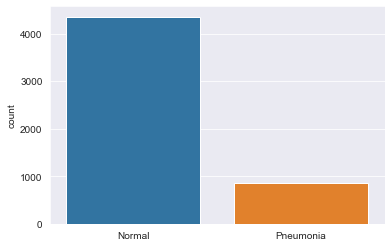

In [17]:
import pandas as pd
import seaborn as sns

l = []
for i in train_img:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style("darkgrid")
sns.countplot(l)

In [18]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state = 42)

In [19]:
lr.fit(train_img, train_y)

LogisticRegression(random_state=42)

In [20]:
lr.score(test_img,test_y)

0.6778846153846154

In [21]:
y_pred = lr.predict(test_img)

In [22]:
from sklearn.metrics import plot_confusion_matrix, accuracy_score, confusion_matrix, plot_roc_curve, \
make_scorer, recall_score, precision_score, f1_score

In [23]:
recall_score(test_y, y_pred)

0.2905982905982906

In [24]:
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier(criterion = "entropy", max_depth = 15,
                          min_samples_split= 5, n_estimators= 700,
                          max_features = 'log2', random_state = 42)

In [25]:
rf.fit(train_img, train_y)

RandomForestClassifier(criterion='entropy', max_depth=15, max_features='log2',
                       min_samples_split=5, n_estimators=700, random_state=42)

In [26]:
from sklearn.model_selection import cross_val_score
cross_val_score(rf, test_img, test_y, cv = 5)

array([0.768     , 0.72      , 0.76      , 0.728     , 0.78225806])

In [27]:
print(f'Test score of random forest model: {rf.score(test_img, test_y)}')

Test score of random forest model: 0.7291666666666666


In [28]:
#baseline model
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(20, activation='relu', input_shape=(65536,))) # 2 hidden layers
model.add(layers.Dense(7, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                1310740   
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 147       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 40        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 1,310,933
Trainable params: 1,310,933
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.compile(optimizer='sgd',
             loss = 'binary_crossentropy',
             metrics =  ['accuracy'])

histoire = model.fit(train_img,
                    train_y,
                    epochs = 50,
                    batch_size = 32,
                    validation_data=(val_img,val_y))

Epoch 1/50
163/163 [==============================] - 1s 7ms/step - loss: 627.4537 - accuracy: 0.7387 - val_loss: 0.7066 - val_accuracy: 0.5000
Epoch 2/50
163/163 [==============================] - 1s 6ms/step - loss: 0.6104 - accuracy: 0.7429 - val_loss: 0.7298 - val_accuracy: 0.5000
Epoch 3/50
163/163 [==============================] - 1s 6ms/step - loss: 0.5898 - accuracy: 0.7429 - val_loss: 0.7522 - val_accuracy: 0.5000
Epoch 4/50
163/163 [==============================] - 1s 6ms/step - loss: 0.5799 - accuracy: 0.7429 - val_loss: 0.7708 - val_accuracy: 0.5000
Epoch 5/50
163/163 [==============================] - 1s 6ms/step - loss: 0.5751 - accuracy: 0.7429 - val_loss: 0.7852 - val_accuracy: 0.5000
Epoch 6/50
163/163 [==============================] - 1s 6ms/step - loss: 0.5726 - accuracy: 0.7429 - val_loss: 0.7963 - val_accuracy: 0.5000
Epoch 7/50
163/163 [==============================] - 1s 6ms/step - loss: 0.5714 - accuracy: 0.7429 - val_loss: 0.8050 - val_accuracy: 0.5000
Epoc

In [30]:
results_train = model.evaluate(train_img, train_y)

163/163 [==============================] - 1s 3ms/step - loss: 0.5700 - accuracy: 0.7429


In [31]:
results_test = model.evaluate(test_img,test_y)

20/20 [==============================] - 0s 3ms/step - loss: 0.6952 - accuracy: 0.6250


In [32]:
results_train

[0.5699953436851501, 0.7429064512252808]

In [33]:
results_test

[0.6952381730079651, 0.625]

In [34]:
yhat_classes = model.predict_classes(test_img, verbose = 0)
yhat_classes = yhat_classes[:, 0]
recall_score(test_y, yhat_classes)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


0.0

In [35]:

from keras import regularizers

# CNN build
np.random.seed(123)
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                        padding = "same",
                       input_shape = (256,256,1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (4, 4), activation='relu', 
                       padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu',
                       padding= 'same'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      16416     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 65536)            

In [36]:
history = model.fit(train_images,
                    train_y,
                    steps_per_epoch= 20,
                    epochs=20,
                    batch_size=16,
                    validation_data=(val_images, val_y))
print(f"Training Score of first convolution neural network: {model.evaluate(train_images, train_y)}")
print(f"Test Score of first convolution neural network: {model.evaluate(test_images, test_y)}")

Epoch 1/20
20/20 [==============================] - 11s 565ms/step - loss: nan - accuracy: 0.6625 - val_loss: nan - val_accuracy: 0.5000
Epoch 2/20
20/20 [==============================] - 11s 548ms/step - loss: nan - accuracy: 0.7219 - val_loss: nan - val_accuracy: 0.5000
Epoch 3/20
20/20 [==============================] - 11s 557ms/step - loss: nan - accuracy: 0.7000 - val_loss: nan - val_accuracy: 0.5000
Epoch 4/20
20/20 [==============================] - 11s 564ms/step - loss: nan - accuracy: 0.7656 - val_loss: nan - val_accuracy: 0.5000
Epoch 5/20
20/20 [==============================] - 11s 554ms/step - loss: nan - accuracy: 0.7437 - val_loss: nan - val_accuracy: 0.5000
Epoch 6/20
20/20 [==============================] - 11s 561ms/step - loss: nan - accuracy: 0.7063 - val_loss: nan - val_accuracy: 0.5000
Epoch 7/20
20/20 [==============================] - 11s 556ms/step - loss: nan - accuracy: 0.7219 - val_loss: nan - val_accuracy: 0.5000
Epoch 8/20
20/20 [=======================

In [37]:
yhat_classes = model.predict_classes(test_images, verbose = 0)
yhat_classes = yhat_classes[:, 0]
recall_score(test_y, yhat_classes)

0.0

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      16416     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 65536)            

In [39]:
from keras.models import Sequential
model = models.Sequential()
model = Sequential()
model.add(layers.Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(layers.Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(layers.Dropout(0.1))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(layers.Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(layers.Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(layers.Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(layers.Flatten())
model.add(layers.Dense(units = 128 , activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])


model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

history = model.fit(train_images,
                    train_y,
                    steps_per_epoch=50,
                    epochs=20,
                    batch_size=8,
                    validation_data=(val_images, val_y))



print(f"\nTraining Score: {model.evaluate(train_images, train_y)}")
print(f"\nTest Score: {model.evaluate(test_images, test_y)}")

Epoch 1/20
50/50 [==============================] - 38s 768ms/step - loss: 0.9782 - acc: 0.7250 - val_loss: 0.6980 - val_acc: 0.7500
Epoch 2/20
50/50 [==============================] - 34s 676ms/step - loss: 0.4519 - acc: 0.8125 - val_loss: 0.4884 - val_acc: 0.8125
Epoch 3/20
50/50 [==============================] - 37s 748ms/step - loss: 0.3756 - acc: 0.8200 - val_loss: 0.6503 - val_acc: 0.7500
Epoch 4/20
50/50 [==============================] - 34s 682ms/step - loss: 0.3076 - acc: 0.8625 - val_loss: 0.6813 - val_acc: 0.8125
Epoch 5/20
50/50 [==============================] - 34s 672ms/step - loss: 0.3281 - acc: 0.8550 - val_loss: 0.5329 - val_acc: 0.7500
Epoch 6/20
50/50 [==============================] - 34s 679ms/step - loss: 0.3366 - acc: 0.8450 - val_loss: 1.0012 - val_acc: 0.5625
Epoch 7/20
50/50 [==============================] - 37s 748ms/step - loss: 0.3492 - acc: 0.8675 - val_loss: 0.8159 - val_acc: 0.5000
Epoch 8/20
50/50 [==============================] - 39s 777ms/step - 

In [40]:

print(f"\nTraining Score: {model.evaluate(train_images, train_y)}")
print(f"\nTest Score: {model.evaluate(test_images, test_y)}")

163/163 [==============================] - 43s 262ms/step - loss: 1.6050 - acc: 0.7441

Training Score: [1.605043888092041, 0.744056761264801]
20/20 [==============================] - 5s 266ms/step - loss: 2.9550 - acc: 0.6250

Test Score: [2.9550492763519287, 0.625]


In [41]:
yhat_classes = model.predict_classes(test_images, verbose = 0)
yhat_classes = yhat_classes[:, 0]
recall_score(test_y, yhat_classes)

0.0

In [42]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 256, 256, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 64)       

In [43]:
model = Sequential()
model.add(layers.Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(256,256,1)))

model.add(layers.MaxPool2D(pool_size=2, strides=2))


model.add(layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(layers.MaxPool2D(pool_size=2, strides=2))


model.add(layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(layers.MaxPool2D(pool_size=2, strides=2))

model.add(layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(layers.MaxPool2D(pool_size=2, strides=2))


model.add(layers.Flatten())
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 254, 254, 16)      160       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 64)       

In [44]:
import os
import tqdm
from os import walk

import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

In [45]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
             loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy',])  

history = model.fit(train_images, 
                    train_y,  
                    epochs=20, 
                    validation_data = (val_images, val_y))

Epoch 1/20
163/163 [==============================] - 78s 476ms/step - loss: 1.5188 - accuracy: 0.7859 - val_loss: 1.6441 - val_accuracy: 0.5625
Epoch 2/20
163/163 [==============================] - 73s 446ms/step - loss: 0.3368 - accuracy: 0.8501 - val_loss: 1.6525 - val_accuracy: 0.5000
Epoch 3/20
163/163 [==============================] - 72s 443ms/step - loss: 0.2670 - accuracy: 0.8875 - val_loss: 2.0742 - val_accuracy: 0.6875
Epoch 4/20
163/163 [==============================] - 77s 474ms/step - loss: 0.2312 - accuracy: 0.9078 - val_loss: 2.3992 - val_accuracy: 0.6250
Epoch 5/20
163/163 [==============================] - 78s 479ms/step - loss: 0.1958 - accuracy: 0.9195 - val_loss: 3.1725 - val_accuracy: 0.5625
Epoch 6/20
163/163 [==============================] - 80s 489ms/step - loss: 0.1636 - accuracy: 0.9344 - val_loss: 3.3090 - val_accuracy: 0.6250
Epoch 7/20
163/163 [==============================] - 83s 507ms/step - loss: 0.1639 - accuracy: 0.9323 - val_loss: 4.5276 - val_ac

In [46]:
print(f"\nTraining Score: {model.evaluate(train_images, train_y)}")
print(f"\nTest Score: {model.evaluate(test_images, test_y)}")

163/163 [==============================] - 18s 112ms/step - loss: 0.0338 - accuracy: 0.9896

Training Score: [0.03382197767496109, 0.9896472096443176]
20/20 [==============================] - 2s 104ms/step - loss: 2.1964 - accuracy: 0.7676

Test Score: [2.1963613033294678, 0.7676281929016113]


In [47]:
yhat_classes = model.predict_classes(test_images, verbose = 0)
yhat_classes = yhat_classes[:, 0]
recall_score(test_y, yhat_classes)

0.47435897435897434

In [48]:
model = models.Sequential()

model.add(layers.Conv2D(filters = 32, strides = (1,1), kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(layers.MaxPool2D((2,2)))

model.add(layers.Conv2D(filters = 64, strides = (2,2), kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(layers.MaxPool2D((2,2)))

model.add(layers.Conv2D(filters = 128, strides = (2,2), kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(layers.MaxPool2D((2,2)))

model.add(layers.Conv2D(filters = 256, strides = (2,2), kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(layers.MaxPool2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(loss = 'BinaryCrossentropy', 
             optimizer = 'adam', 
             metrics = ['accuracy'])




history = model.fit(train_images,
                   train_y, 
                   steps_per_epoch = 30, 
                   epochs = 20,
                   validation_data = (val_images, val_y))
model.summary()



print(f"\nTraining Score: {model.evaluate(train_images, train_y)}")
print(f"\nTest Score: {model.evaluate(test_images, test_y)}")

yhat_classes = model.predict_classes(test_images, verbose = 0)
yhat_classes = yhat_classes[:, 0]
recall_score(test_y, yhat_classes)

Epoch 1/20
30/30 [==============================] - 69s 2s/step - loss: 0.7360 - accuracy: 0.7034 - val_loss: 1.6311 - val_accuracy: 0.6250
Epoch 2/20
30/30 [==============================] - 70s 2s/step - loss: 0.3776 - accuracy: 0.8184 - val_loss: 2.0271 - val_accuracy: 0.7500
Epoch 3/20
30/30 [==============================] - 70s 2s/step - loss: 0.3116 - accuracy: 0.8553 - val_loss: 2.3801 - val_accuracy: 0.6250
Epoch 4/20
30/30 [==============================] - 69s 2s/step - loss: 0.2919 - accuracy: 0.8698 - val_loss: 1.8069 - val_accuracy: 0.6250
Epoch 5/20
30/30 [==============================] - 69s 2s/step - loss: 0.2545 - accuracy: 0.8880 - val_loss: 2.3197 - val_accuracy: 0.6250
Epoch 6/20
30/30 [==============================] - 69s 2s/step - loss: 0.1968 - accuracy: 0.9187 - val_loss: 2.2417 - val_accuracy: 0.6250
Epoch 7/20
30/30 [==============================] - 71s 2s/step - loss: 0.1540 - accuracy: 0.9340 - val_loss: 3.8111 - val_accuracy: 0.6250
Epoch 8/20
30/30 [==

0.5598290598290598